In [ ]:
pip install --upgrade  xgboost lightgbm pandas dask[complete] dask-ml[complete] distributed pyarrow joblib adlfs dask_lightgbm

In [1]:
import dask
import glob
import joblib
import fsspec

import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt

from datetime import datetime
from dask.distributed import Client
from dask_lightgbm import LGBMRegressor
from dask_ml.xgboost import XGBRegressor
from azureml.core import Workspace, Dataset, Model

In [2]:
from azureml.core import Workspace, Experiment, Datastore, Dataset, Environment

In [3]:
ws = Workspace.from_config()
ws


Workspace.create(name='qtmNpeMlWu2Ws0', subscription_id='6699340d-f248-4d52-8e5c-d0f06713b006', resource_group='qtmNpeMlWu2Rg0')

In [ ]:
keyvault.set_secret("sec1", "some_value")

In [7]:
keyvault=ws.get_default_keyvault()

In [ ]:
keyvault.get_secret("sec1")

In [4]:
c = Client('10.0.0.5:8786')
# c = Client()

c

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/distributed/client.py:1130: VersionMismatchWarning: Mismatched versions found

+---------+---------------+---------------+---------------+
| Package | client        | scheduler     | workers       |
+---------+---------------+---------------+---------------+
| numpy   | 1.18.5        | 1.19.2        | 1.19.2        |
| python  | 3.6.9.final.0 | 3.6.2.final.0 | 3.6.2.final.0 |
| toolz   | 0.11.1        | 0.10.0        | 0.10.0        |
+---------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


Client Scheduler: tcp://10.0.0.5:8786 Dashboard: http://10.0.0.5:8787/status,Cluster Workers: 25 Cores: 200 Memory: 1.48 TB


In [ ]:
# def install():
#     import os
#     os.system("pip install dask-lightgbm")  # or pip

# #     os.system("pip install pyarrow")  # or pip
# #     os.system("pip install fastparquet")  # or pip
# #     os.system("pip install fsspec")  # or pip

# c.run(install)  # Run on all workers

In [8]:
# df.head()

import dask.dataframe as dd

STORAGE_OPTIONS={'account_name': 'adlsquantumtest', 'account_key': keyvault.get_secret("adlsquantumtestaccountkey")}
df = dd.read_parquet('abfs://mltraining/ISDWeather_compact/*/*/*.parquet', storage_options=STORAGE_OPTIONS,engine='pyarrow').repartition(npartitions=200).persist()
%time df.head()


CPU times: user 91 ms, sys: 9.41 ms, total: 100 ms
Wall time: 20.5 s


,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
0,999999,03067,2018-01-26 21:55:00,38.870,-100.963,875.0,NaN,NaN,8.3,NaN,...,NaN,NaN,NaN,NaN,OAKLEY 19 SSW,US,999999-03067,2018,26,1.0
1,942940,99999,2018-01-21 13:00:00,-19.252,146.765,5.0,110.0,3.6,27.0,NaN,...,NaN,NaN,NaN,NaN,TOWNSVILLE,AS,942940-99999,2018,21,1.0
2,999999,03067,2018-01-27 06:35:00,38.870,-100.963,875.0,NaN,NaN,-6.5,NaN,...,NaN,NaN,NaN,NaN,OAKLEY 19 SSW,US,999999-03067,2018,27,1.0
3,136150,99999,2018-01-07 14:20:00,41.415,19.721,38.0,320.0,2.1,16.0,NaN,...,NaN,NaN,NaN,NaN,TIRANA RINAS,AL,136150-99999,2018,7,1.0
4,999999,94074,2018-01-23 15:45:00,40.807,-104.755,1643.0,NaN,NaN,-2.2,NaN,...,NaN,NaN,NaN,NaN,NUNN 7 NNE,US,999999-94074,2018,23,1.0


In [ ]:
##
import dask.dataframe as dd

STORAGE_OPTIONS={'account_name': 'adlsquantumtest', 'account_key':"Ljxd+gqrKwDICArFncQtcACUpbG4TLisyNuYObzgFvbLCRsrTasw6tY5cLYdZ9VxY9sTlCPt09j9ZeG57EjwGw=="}
df = dd.read_parquet('abfs://mltraining/ISDWeather_compact/*/*/*.parquet', storage_options=STORAGE_OPTIONS,engine='pyarrow').repartition(npartitions=200).persist()
%time df.head()

In [9]:
df = df.set_index(dd.to_datetime(df.datetime).dt.floor('d'), sorted=False).persist()
%time len(df)



CPU times: user 405 ms, sys: 16.9 ms, total: 421 ms
Wall time: 42.6 s


370647786

In [10]:
df.head()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
2018-01-01,939940,99999,2018-01-01 18:00:00,-29.250,-177.933,50.0,80.0,2.1,20.6,1015.9,...,NaN,6.0,0.0,NaN,RAOUL ISLAND AWS,NZ,939940-99999,2018,1,1.0
2018-01-01,284400,99999,2018-01-01 17:00:00,56.743,60.803,233.0,140.0,5.0,-11.0,NaN,...,NaN,NaN,NaN,NaN,KOLTSOVO,RS,284400-99999,2018,1,1.0
2018-01-01,720617,00208,2018-01-01 01:55:00,29.800,-95.900,51.0,350.0,7.2,3.0,NaN,...,NaN,NaN,NaN,NaN,HOUSTON EXECUTIVE AIRPORT,US,720617-00208,2018,1,1.0
2018-01-01,722416,12971,2018-01-01 00:51:00,29.709,-98.046,197.0,20.0,9.3,0.6,1031.5,...,NaN,1.0,0.0,NaN,NEW BRAUNFELS MUNICIPAL AP,US,722416-12971,2018,1,1.0
2018-01-01,720342,53947,2018-01-01 13:55:00,35.864,-98.421,472.0,10.0,3.6,-16.5,NaN,...,NaN,NaN,NaN,NaN,WATONGA AIRPORT,US,720342-53947,2018,1,1.0


In [12]:
df.tail()

,usaf,wban,datetime,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,...,pastWeatherIndicator,precipTime,precipDepth,snowDepth,stationName,countryOrRegion,p_k,year,day,version
2020-09-21,722217,63881,2020-09-21 04:59:00,32.564,-82.985,94.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,W H `BUD` BARRON AIRPORT,US,722217-63881,2020,21,1.0
2020-09-21,722230,13894,2020-09-21 05:59:00,30.688,-88.246,67.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MOBILE REGIONAL AIRPORT,US,722230-13894,2020,21,1.0
2020-09-21,723260,13891,2020-09-21 04:59:00,35.818,-83.986,299.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,MC GHEE TYSON AIRPORT,US,723260-13891,2020,21,1.0
2020-09-21,727690,24137,2020-09-21 06:59:00,48.603,-112.375,1170.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,CUT BANK MUNICIPAL AIRPORT,US,727690-24137,2020,21,1.0
2020-09-21,722053,12841,2020-09-21 04:59:00,28.545,-81.333,34.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,EXECUTIVE AIRPORT,US,722053-12841,2020,21,1.0


In [13]:
%time df.describe().compute()

CPU times: user 8.55 s, sys: 63.3 ms, total: 8.62 s
Wall time: 37.9 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
count,3.706478e+08,3.706478e+08,3.706478e+08,3.060065e+08,3.181159e+08,3.627686e+08,1.471140e+08,3.750366e+07,1.277659e+07,9.089260e+07,9.089260e+07,3.102138e+06,3.706478e+08,3.706478e+08,370647786.0
mean,3.636270e+01,-3.680643e+01,3.826631e+02,1.658556e+02,3.402247e+00,1.258575e+01,1.014749e+03,3.487568e+01,4.066340e+00,1.501979e+01,2.291440e+03,1.385312e+01,2.018929e+03,1.559385e+01,1.0
std,2.316813e+01,7.867386e+01,6.710925e+02,1.139083e+02,2.823624e+00,1.254058e+01,9.176012e+00,3.027046e+01,3.085517e+00,2.938022e+01,4.192804e+03,2.622940e+01,7.804791e-01,8.807404e+00,0.0
min,-9.000000e+01,-1.799990e+02,-3.880000e+02,0.000000e+00,0.000000e+00,-9.130000e+01,8.614000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.018000e+03,1.000000e+00,1.0
25%,3.325400e+01,-9.489000e+01,4.600000e+01,1.000000e+02,2.000000e+00,8.600000e+00,1.012200e+03,1.000000e+01,2.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.018000e+03,9.000000e+00,1.0
50%,4.147800e+01,-7.154500e+01,1.980000e+02,2.100000e+02,3.600000e+00,1.700000e+01,1.017200e+03,6.100000e+01,6.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,2.019000e+03,1.600000e+01,1.0
75%,4.876700e+01,1.790000e+01,4.450000e+02,2.900000e+02,5.700000e+00,2.780000e+01,1.030300e+03,7.100000e+01,8.000000e+00,2.400000e+01,9.999000e+03,6.300000e+01,2.020000e+03,2.400000e+01,1.0
max,8.365600e+01,1.799980e+02,9.999000e+03,3.600000e+02,9.000000e+01,6.150000e+01,1.090000e+03,9.900000e+01,9.000000e+00,9.900000e+01,9.999000e+03,7.000000e+02,2.020000e+03,3.100000e+01,1.0


In [14]:
%time places = df.groupby(df.index)[['longitude', 'latitude', 'year']].mean().compute()

CPU times: user 102 ms, sys: 8.57 ms, total: 110 ms
Wall time: 808 ms


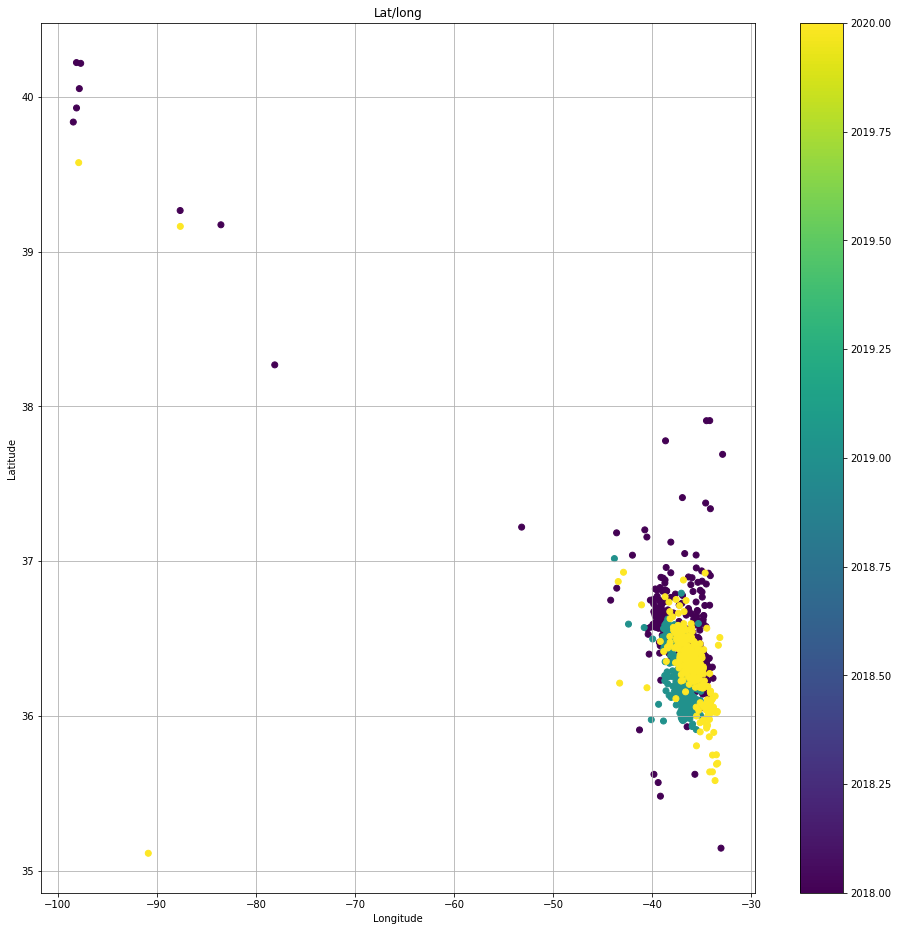

In [15]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.colorbar()

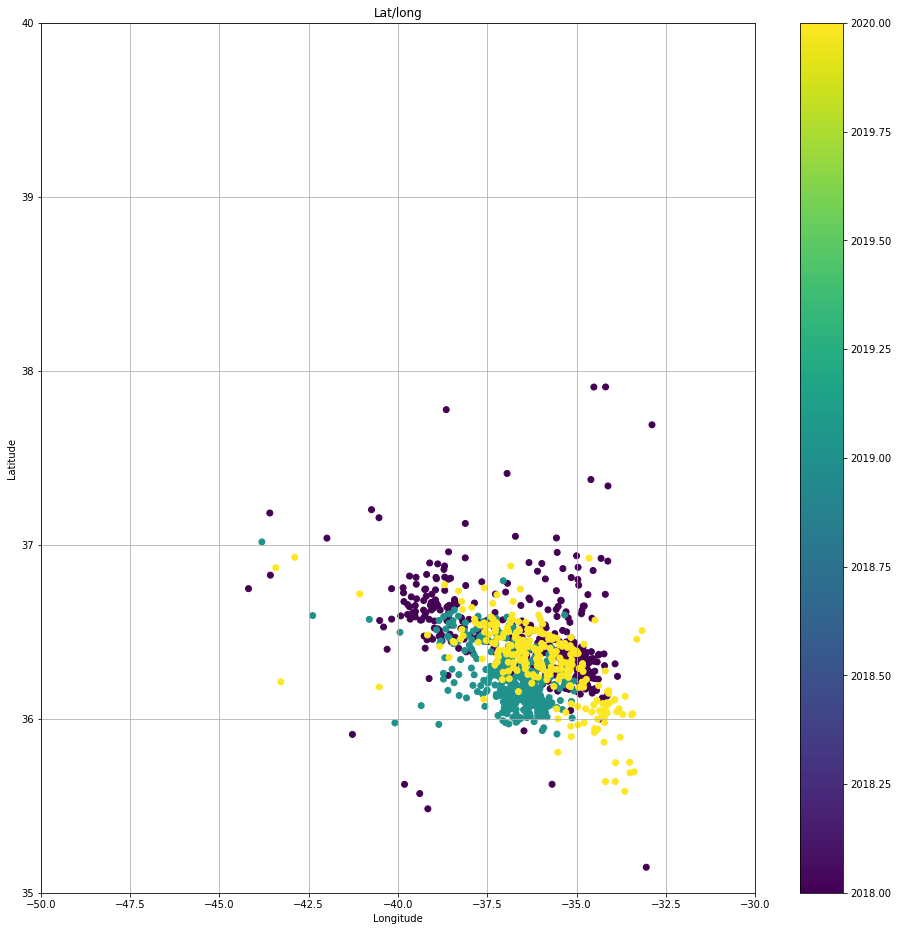

In [16]:
plt.figure(figsize=(16, 16))
plt.scatter(places.longitude, places.latitude, c=places.year)
plt.title('Lat/long')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim([-50, -30]) # zoom in 
plt.ylim([35, 40])   # zoom in 
plt.grid()
plt.colorbar()

In [17]:
%time means = df.groupby(df.index).mean().compute()
means.head()

CPU times: user 130 ms, sys: 7.83 ms, total: 138 ms
Wall time: 30 s


,latitude,longitude,elevation,windAngle,windSpeed,temperature,seaLvlPressure,presentWeatherIndicator,pastWeatherIndicator,precipTime,precipDepth,snowDepth,year,day,version
2018-01-01,36.385272,-37.308480,384.769140,179.016368,3.930796,-0.549780,1017.674714,28.607884,4.160066,17.072870,3172.529276,21.165006,2018.0,1.0,1.0
2018-01-02,36.440033,-37.321360,386.468903,173.116035,3.769078,0.215078,1017.421572,30.444729,4.275907,17.015934,2987.017817,18.976822,2018.0,2.0,1.0
2018-01-03,36.465432,-37.812738,381.724026,183.661786,3.950227,1.544384,1015.245467,32.456113,4.343357,16.361008,2809.673376,17.346969,2018.0,3.0,1.0
2018-01-04,36.560312,-38.185139,380.853804,177.255851,3.585027,1.562768,1014.115661,32.432361,4.264693,15.839844,2708.240790,19.648033,2018.0,4.0,1.0
2018-01-05,36.526184,-38.143653,384.692698,167.716220,3.443562,1.431866,1013.047978,29.623781,4.105540,16.927881,3014.217619,15.187409,2018.0,5.0,1.0


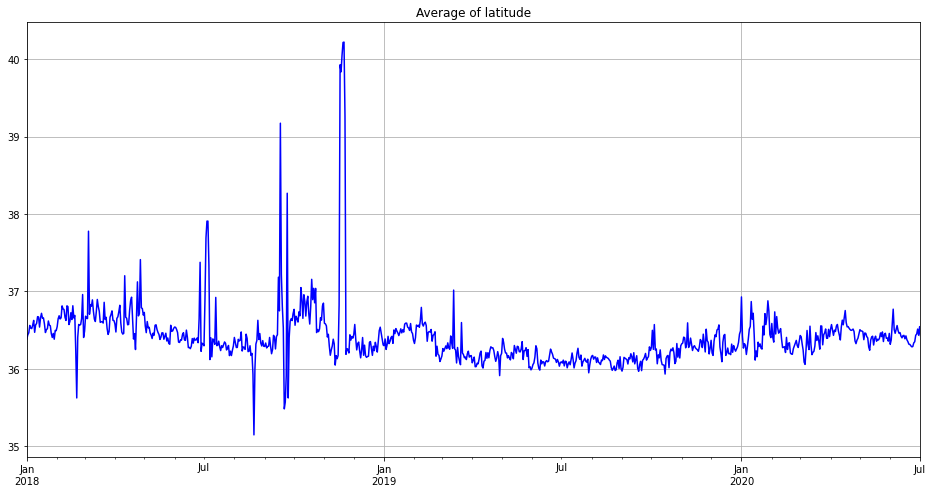

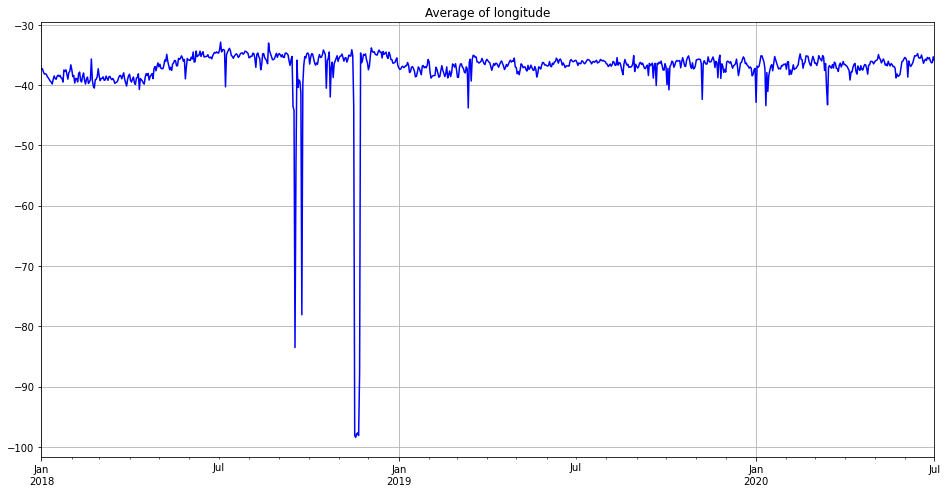

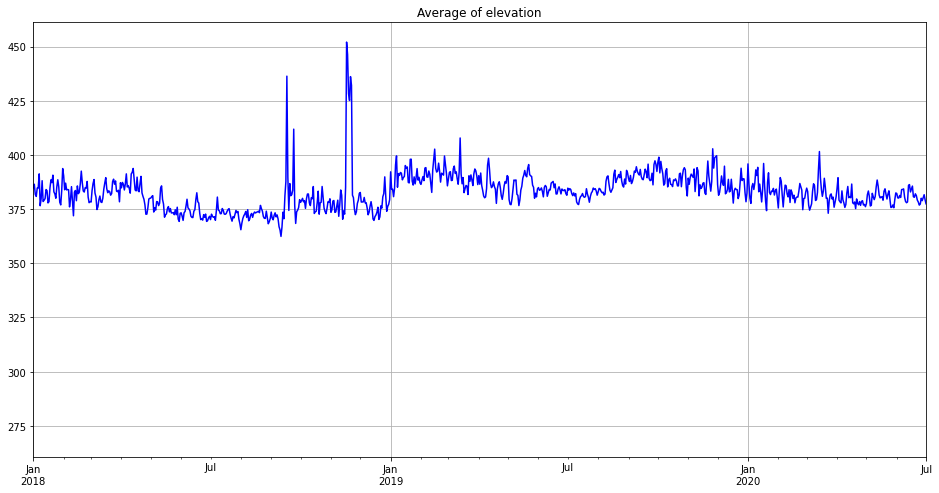

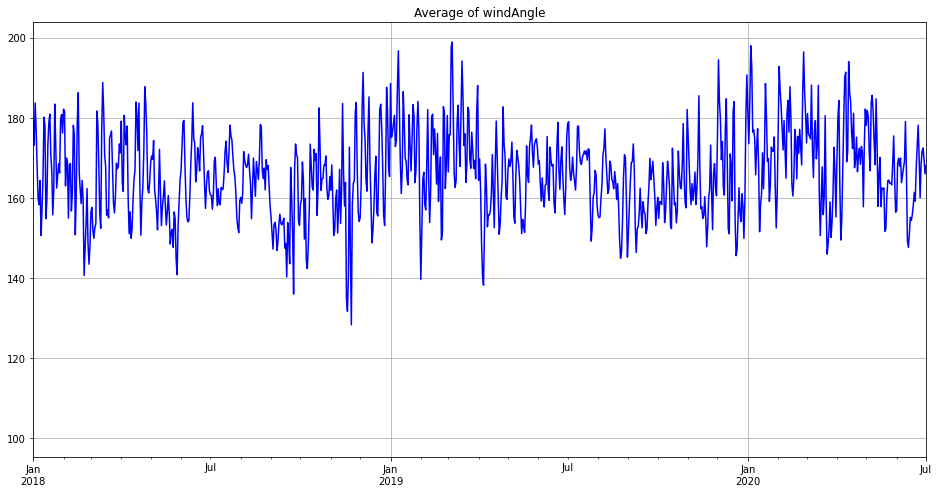

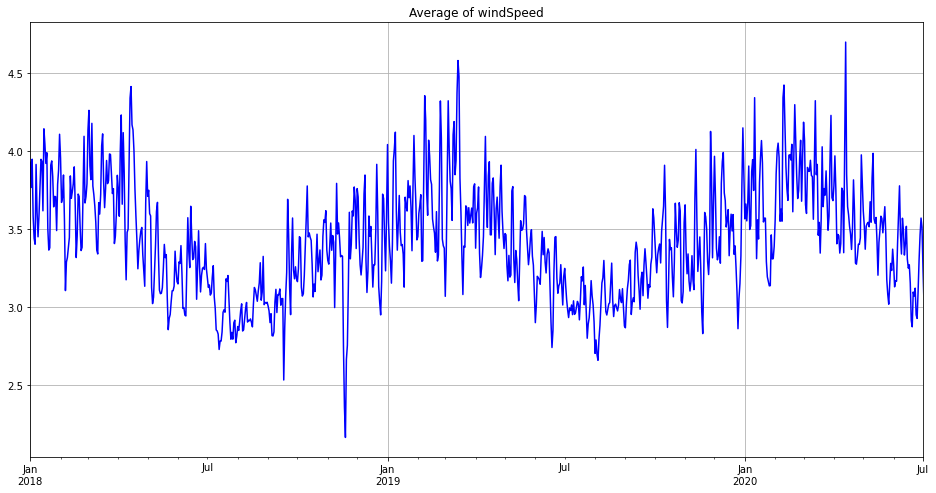

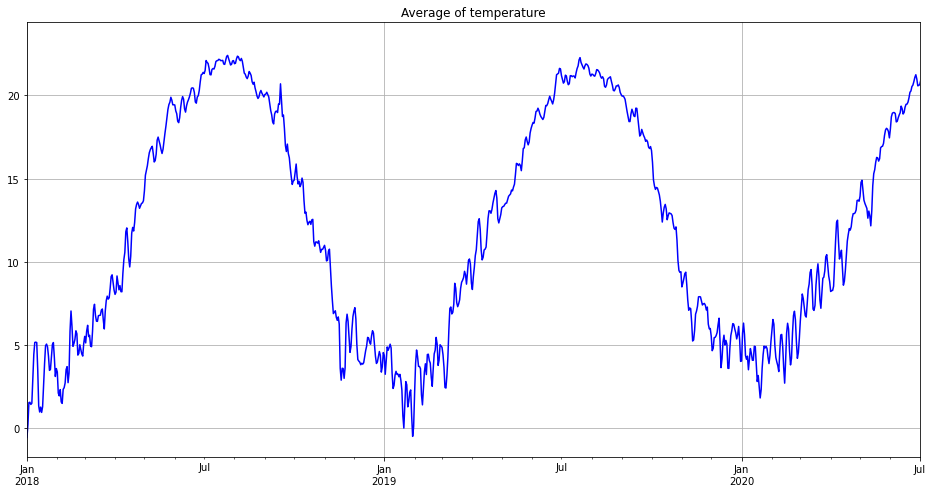

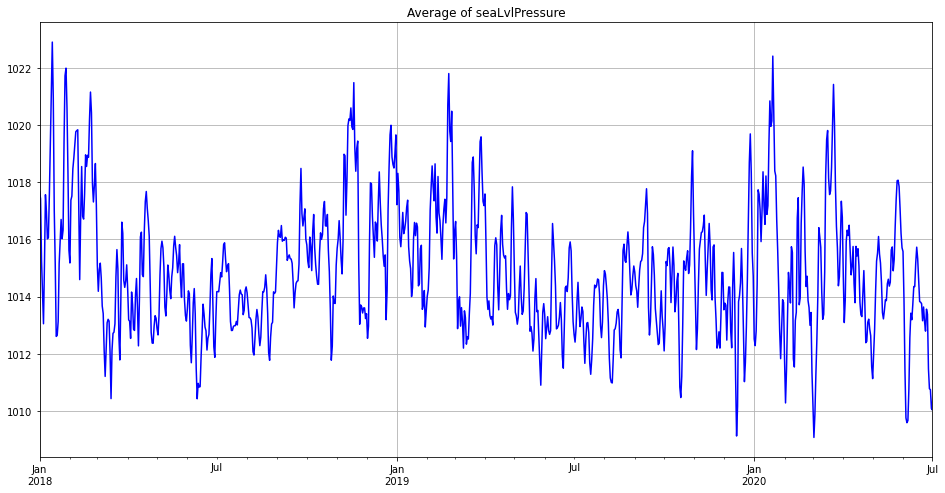

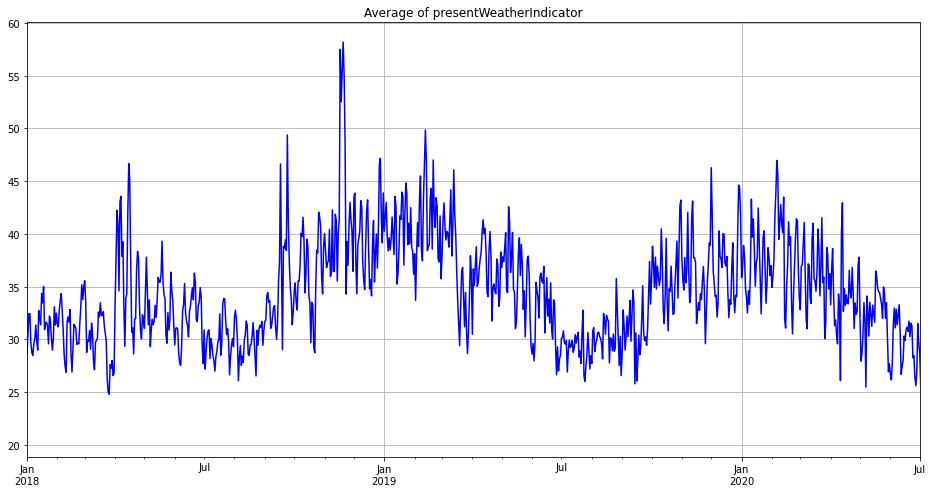

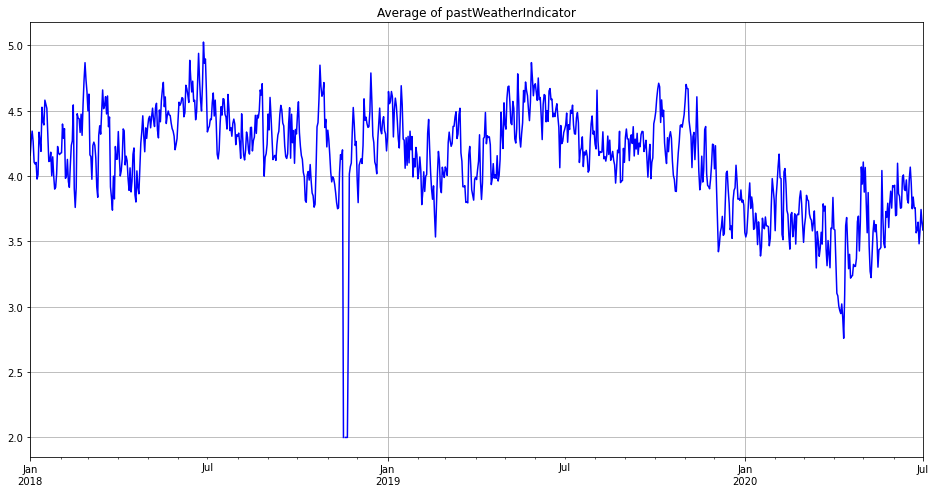

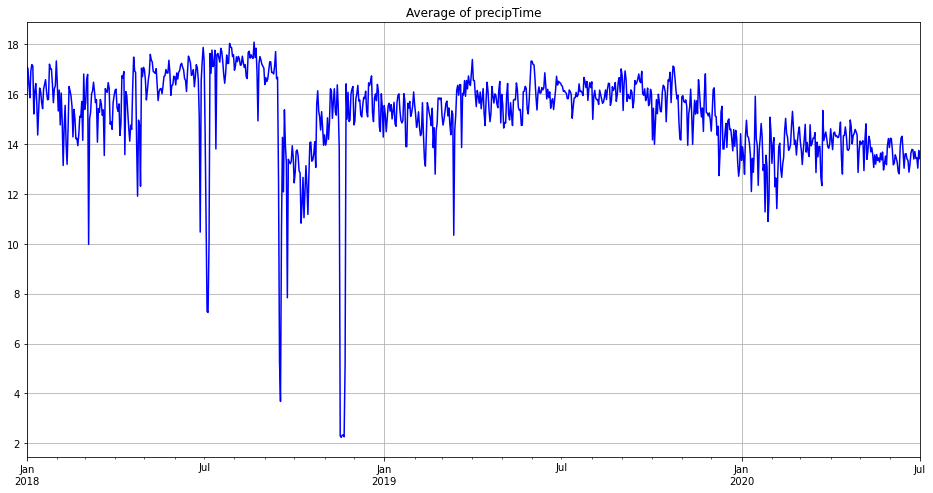

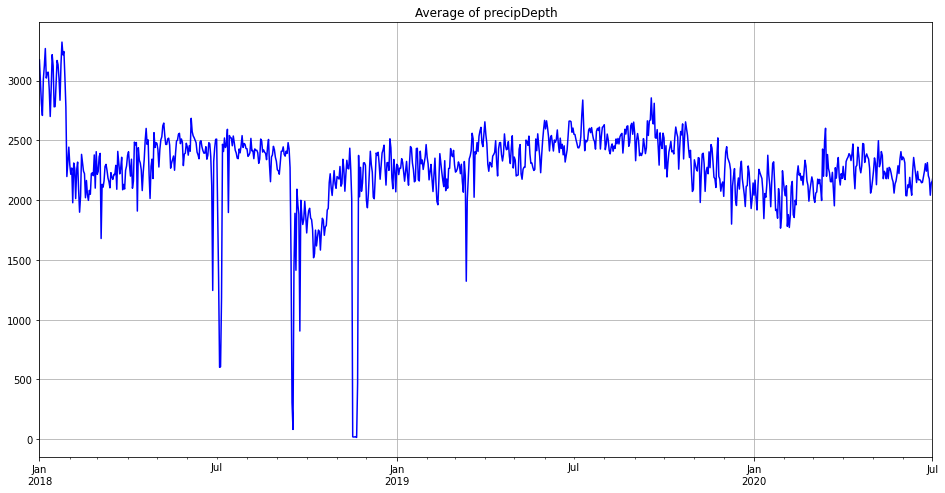

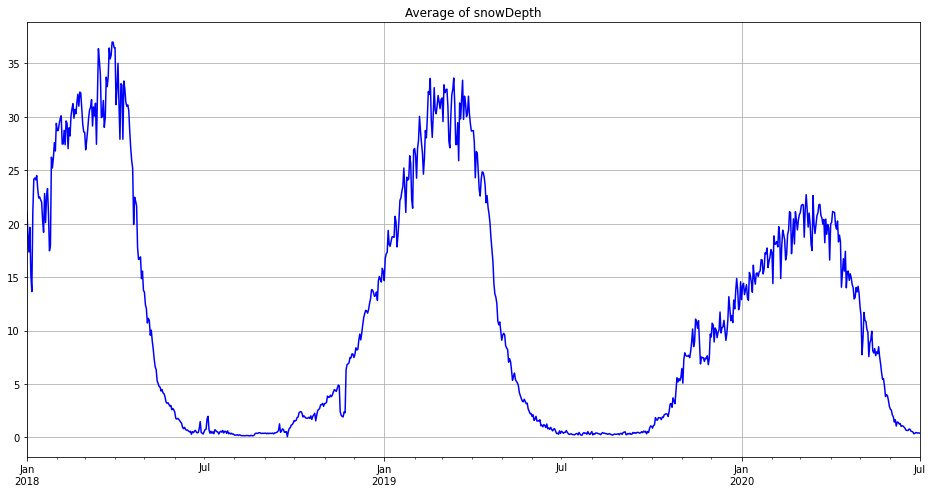

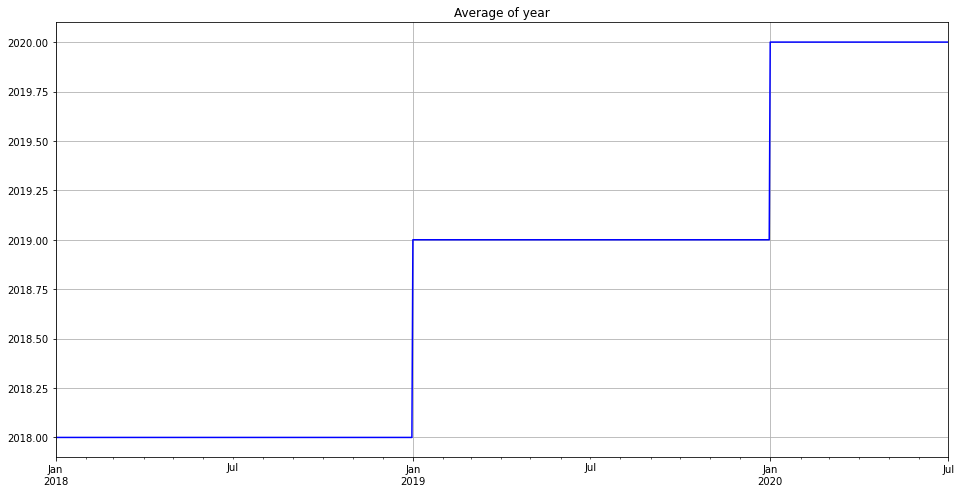

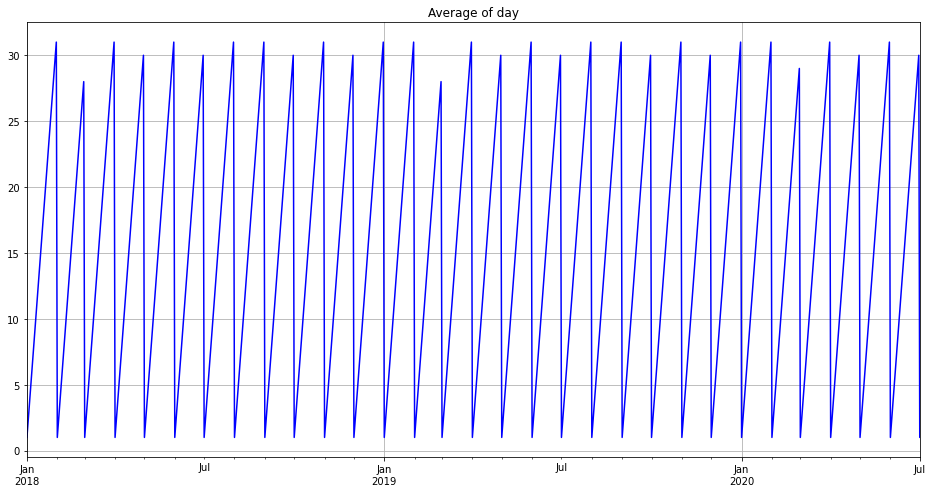

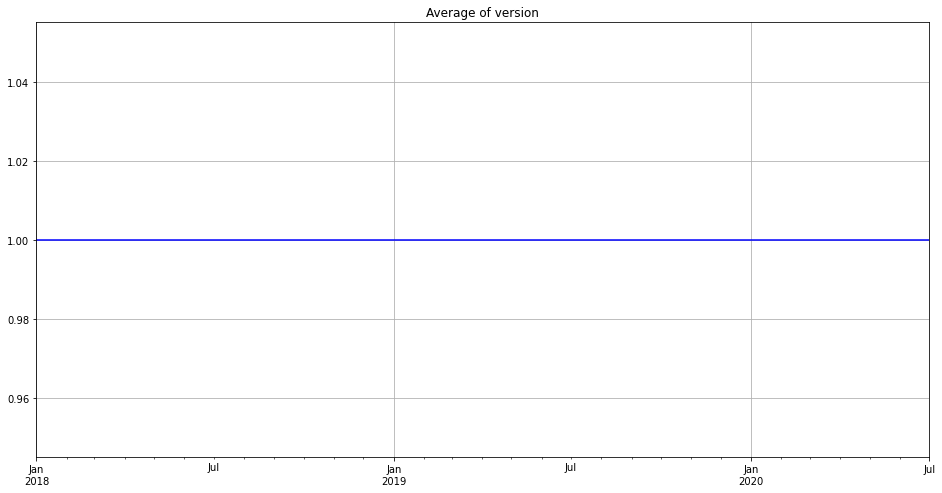

In [18]:
for col in list(means.columns):
    fig = plt.figure(figsize=(16, 8))
    #plt.style.use('dark_background')
    means[col].plot(color='b')
    plt.title('Average of {}'.format(col))
    plt.xlim([datetime(2018, 1, 1), datetime(2020, 7, 1)])
    plt.grid()

In [ ]:
## insert any Pandas-like Dask transformation code 
df['temperature'] = df['temperature']*(9/5)+32 # 'Merica

In [ ]:
# begin data prep for ML 
df = df.fillna(0)

In [ ]:
cols = list(df.columns)
cols = [col for col in cols if df.dtypes[col] != 'object' and col not in ['version', 'datetime']]
cols

In [ ]:
X = df[[col for col in cols if col not in ['temperature']]].persist()
y = df.temperature.persist()
# end data prep for ML

In [ ]:
xgb = XGBRegressor(n_estimators=16)
%time xgb.fit(X, y)

In [ ]:
%time y_pred = xgb.predict(X).compute()

In [ ]:
%time rmse = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
print(f'Training RMSE: {round(rmse, 3)}')

In [ ]:
lgbm = LGBMRegressor(n_estimators=16)
%time lgbm.fit(X, y)

In [ ]:
%time y_pred = lgbm.predict(X).compute()

In [ ]:
%time rmse2 = (((y.to_dask_array().compute()-y_pred)**2).mean())**.5
print(f'Training RMSE: {round(rmse2, 3)}')

In [ ]:
if rmse2 < rmse:
    best_model = 'lgbm'
else:
    best_model = 'xgb'

best_model

In [ ]:
model_path = f'{best_model}_noaa_isd.joblib.dat'
joblib.dump(xgb, model_path) if best_model is 'xgb' else joblib.dump(lgbm, model_path)
model2 = joblib.load(model_path)

In [ ]:
model = Model.register(ws, 
                       model_name      = f'{best_model}-noaa-isd', 
                       model_path      = model_path,
                       description     = f'NOAA ISD temperature predictor')

In [3]:
!curl grafana.sipp.eng.t-mobile.com

curl: (6) Could not resolve host: grafana.sipp.eng.t-mobile.com
